In [146]:
import graphviz
import numpy as np
import collections
import math

In [78]:
def nodes_edges(root):
    nodes = []
    edges = []
    
    q = collections.deque()
    q.append(root)
    visited = set()
    
    while q:
        curr = q.popleft()
        nodes.append(curr)
        
        for child in curr._prev:
            edges.append((child, curr))
            if child not in visited:
                q.append(child)
                visited.add(child)   
    return nodes, edges

def build_graph(node):
    dot = graphviz.Digraph(format="svg", graph_attr={'rankdir': 'LR'})
    
    nodes, edges = nodes_edges(node)
    
    for n in nodes:
        uid = str(id(n))
        
        dot.node(name=uid, label=f"{{{n.label} | data = {n.data} | grad = {n.grad}}}", shape="record")
        
        if n._op:
            dot.node(name=uid+n._op, label=n._op)
            dot.edge(uid+n._op, uid)      
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot
    

In [228]:
class Value:
    # need to make a scalar

    def __init__(self, data, _children=(), op=None, label=None):
        self.data = data
        self._prev = set(_children)
        self._op = op
        self._backward = lambda: None
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return f"Value({self.data})"
    
    def __neg__(self):
        return self * -1
    
    def __mul__(self, other):
        other = Value(other, label=other) if not isinstance(other, Value) else other
        
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward
        
        return out
    
    def __add__(self, other):
        other = Value(other, label=other) if not isinstance(other, Value) else other
        
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __pow__(self, exponent):   
        out = Value(self.data**exponent, (self,), f"^{exponent}")
        
        def _backward():
            self.grad += (exponent * (self.data ** (exponent - 1))) * out.grad
        
        out._backward = _backward
        
        return out
    
    def __truediv__(self, other):
        return self * (other ** (-1))
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "e")
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad += (1 - t**2)
        
        out._backward = _backward
        
        return out
        
    
    def backward(self):
        def topo(root):
            res = []
            visited = set()
            def dfs(i):
                for child in i._prev:
                    if child not in visited:
                        visited.add(child)
                        dfs(child)
                res.append(i)
            dfs(root)
            return res
        nodes = topo(self)
        
        self.grad = 1.0
        
        for n in reversed(nodes):
            n._backward()
    

In [229]:
a = Value(1.5, label="a")
b = Value(2.5, label="b")
c = a + b
d = Value(0.5, label="d")
e = c * d
e.label = "e"
c.label = "c"
o = e.tanh(); o.label = "o"
o.backward()

0.07065082485316443

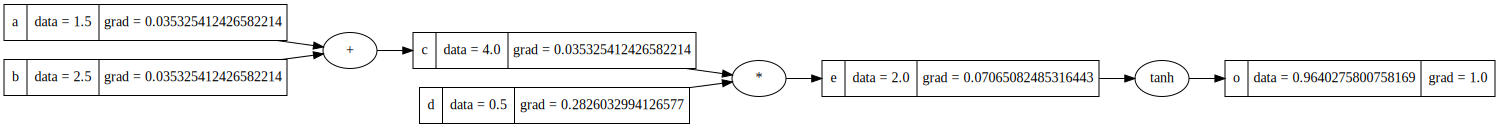

In [225]:
build_graph(o)